### Import modules

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyRegressor

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

import altair as alt

In [2]:
# Save a vega-lite spec and a PNG blob for each plot in the notebook
alt.renderers.enable('mimetype')
# Handle large data sets without embedding them in the notebook
alt.data_transformers.enable('data_server')

DataTransformerRegistry.enable('data_server')

## Read the data

In [3]:
# Read the data
df = pd.read_csv('data/PJME_hourly.csv')

# Remove spaces from column names
df.columns = df.columns.str.replace(' ', '')

# Convert Datetime column to datetime data type
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Set index to datetime column
df = df.set_index('Datetime')

# Sort the index to ascending order
df = df.sort_index()

# Rename the PJME_MW column to target column
df = df.rename(columns={'PJME_MW': 'target'})

# Check head of the resulting dataframe
df.head()

,target
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0


## Split into train and test

In [4]:
df_train, df_test = train_test_split(df, test_size=0.2, shuffle=False, random_state=123)
print(df_train.shape)
print(df_test.shape)

(116292, 1)
(29074, 1)


## Visualize the data - Basic EDA

In [5]:
# Function to plot the raw data
def plot_data(data, x_axis, y_axis):
    """
    Plots line chart of the time series data (y-axis) against time (x-axis)

    Parameters
    ----------
    data: pd.DataFrame
        input dataframe
    x_axis: str
        the name of the time(datetime) column 
    y_axis: str
        the name of the time series data column

    Returns
    ----------
    lines: altair.vegalite.v4.api.Chart
        altair chart object 
    """
    data = data.reset_index()
    lines = alt.Chart(data).mark_line().encode(
        x=alt.X(x_axis),
        y=alt.Y(y_axis)
    ).properties(
        width=700,
        height=250
    )
    return lines

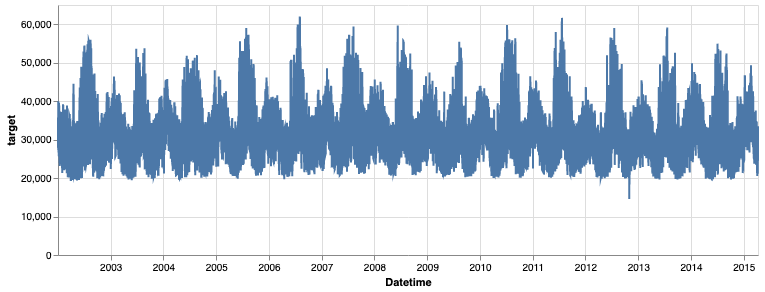

In [6]:
plot_data(df_train, x_axis='Datetime', y_axis='target')

## Separate train and test 

In [7]:
# Add lags
def generate_lags(df, num_lags):
    """
    Creates new features which are lags of the target variable
    Parameters
    ----------
    df: pd.DataFrame
        input dataframe
    num_lags: int
        the number of lags

    Returns
    ----------
    df_tmp: pd.DataFrame
        dataframe with lagged features created
    """
    df_tmp = df.copy()
    for n in range(1, num_lags+1):
        df_tmp[f'lag{n}'] = df_tmp['target'].shift(n)
    df_tmp = df_tmp.iloc[num_lags:]
    return df_tmp

In [8]:
tot_lags = 100
df_train = generate_lags(df=df_train, num_lags=tot_lags)
df_test = generate_lags(df=df_test, num_lags=tot_lags)

/var/folders/mt/bt06kkrx6l95m_pgdc87jxy00000gn/T/ipykernel_93807/1981978083.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_tmp[f'lag{n}'] = df_tmp['target'].shift(n)


In [9]:
df_test.head()

,target,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,...,lag91,lag92,lag93,lag94,lag95,lag96,lag97,lag98,lag99,lag100
Datetime,,,,,,,,,,,,,,,,,,,,,
2015-04-13 19:00:00,28476.0,28620.0,28488.0,28421.0,28395.0,28503.0,28535.0,28767.0,29000.0,29165.0,...,27846.0,30060.0,32363.0,33755.0,33843.0,33012.0,32707.0,32209.0,32049.0,32204.0
2015-04-13 20:00:00,29173.0,28476.0,28620.0,28488.0,28421.0,28395.0,28503.0,28535.0,28767.0,29000.0,...,26208.0,27846.0,30060.0,32363.0,33755.0,33843.0,33012.0,32707.0,32209.0,32049.0
2015-04-13 21:00:00,30295.0,29173.0,28476.0,28620.0,28488.0,28421.0,28395.0,28503.0,28535.0,28767.0,...,25240.0,26208.0,27846.0,30060.0,32363.0,33755.0,33843.0,33012.0,32707.0,32209.0
2015-04-13 22:00:00,28742.0,30295.0,29173.0,28476.0,28620.0,28488.0,28421.0,28395.0,28503.0,28535.0,...,24753.0,25240.0,26208.0,27846.0,30060.0,32363.0,33755.0,33843.0,33012.0,32707.0
2015-04-13 23:00:00,26369.0,28742.0,30295.0,29173.0,28476.0,28620.0,28488.0,28421.0,28395.0,28503.0,...,24694.0,24753.0,25240.0,26208.0,27846.0,30060.0,32363.0,33755.0,33843.0,33012.0


In [10]:
X_train, y_train = (
    df_train.drop(columns=['target']),
    df_train['target']
)
X_test, y_test = (
    df_test.drop(columns=['target']),
    df_test['target']
)

# Print shapes of the resulting train and test data sets
print(f'Shape of X_train and y_train: {X_train.shape, y_train.shape}')
print(f'Shape of X_test and y_test: {X_test.shape, y_test.shape}')

Shape of X_train and y_train: ((116192, 100), (116192,))
Shape of X_test and y_test: ((28974, 100), (28974,))


## Feature Engineering Using Pipeline Transformations

#### Custom Transformer for Automated Feature extraction

In [11]:
class UniveriateTimeSeriesAddFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, num_lags=10):
        self.num_lags = num_lags
        
    def __extract_features(self, X):
        """
        Creates new features from timestamp
        Parameters
        ----------
        X: pd.DataFrame
            input dataframe
        
        Returns
        ----------
        df_features: pd.DataFrame
            dataframe with new features created
        """
        df_features = X.copy()
        df_features = (
                df_features
                .assign(hour = df_features.index.hour)
                .assign(day = df_features.index.day)
                .assign(month = df_features.index.month)
                .assign(day_of_week = df_features.index.dayofweek)
                # .assign(week_of_year = df.index.isocalendar().week)
        )
        df_features = df_features.reset_index()
        return df_features
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        df_features = X.copy()
        df_features = self.__extract_features(df_features)
        df_features = df_features.iloc[:,1:]
        return df_features

In [12]:
preprocessor = Pipeline(
    [
        ('add_lag_step', UniveriateTimeSeriesAddFeatures(num_lags=10)),
        ('stdscaler', StandardScaler())
    ]
)

#### Models

In [13]:
def mape(true, pred):
    return 100.0 * np.mean(np.abs((pred - true) / true))


# make a scorer function that we can pass into cross-validation
mape_scorer = make_scorer(mape, greater_is_better=False)

scoring_metrics = {
    "neg RMSE": "neg_root_mean_squared_error",
    "r2": "r2",
    "mape": mape_scorer,
}

In [14]:
# Function to collate results
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [15]:
results = {}

#### Dummy Regressor

In [16]:
dummy = DummyRegressor()

results["Dummy"] = mean_std_cross_val_scores(
    dummy, X_train, y_train, return_train_score=True, scoring=scoring_metrics
)

pd.DataFrame(results)

,Dummy
fit_time,0.035 (+/- 0.048)
score_time,0.002 (+/- 0.001)
test_neg RMSE,-6439.362 (+/- 250.618)
train_neg RMSE,-6434.573 (+/- 64.006)
test_r2,-0.007 (+/- 0.006)
train_r2,0.000 (+/- 0.000)
test_mape,-15.878 (+/- 0.621)
train_mape,-15.857 (+/- 0.096)


#### Other Models

In [17]:
pipe_ridge = make_pipeline(preprocessor, Ridge(random_state=123))
pipe_xgb = make_pipeline(preprocessor, XGBRegressor(random_state=123))
pipe_rf = make_pipeline(preprocessor, RandomForestRegressor(random_state=123))

models = {
    'ridge': pipe_ridge,
    'xgboost': pipe_xgb,
    'rf_regressor': pipe_rf
}

In [18]:
for (name, model) in models.items():
    results[name] = mean_std_cross_val_scores(
        model, X_train, y_train, return_train_score=True, scoring=scoring_metrics
    )

pd.DataFrame(results)

,Dummy,ridge,xgboost,rf_regressor
fit_time,0.035 (+/- 0.048),0.207 (+/- 0.117),24.445 (+/- 1.326),666.651 (+/- 57.002)
score_time,0.002 (+/- 0.001),0.032 (+/- 0.022),0.089 (+/- 0.009),0.898 (+/- 0.067)
test_neg RMSE,-6439.362 (+/- 250.618),-326.362 (+/- 30.261),-374.793 (+/- 20.079),-356.426 (+/- 22.760)
train_neg RMSE,-6434.573 (+/- 64.006),-325.508 (+/- 8.169),-296.067 (+/- 3.588),-129.015 (+/- 1.060)
test_r2,-0.007 (+/- 0.006),0.997 (+/- 0.001),0.997 (+/- 0.001),0.997 (+/- 0.001)
train_r2,0.000 (+/- 0.000),0.997 (+/- 0.000),0.998 (+/- 0.000),1.000 (+/- 0.000)
test_mape,-15.878 (+/- 0.621),-0.712 (+/- 0.045),-0.847 (+/- 0.053),-0.735 (+/- 0.060)
train_mape,-15.857 (+/- 0.096),-0.709 (+/- 0.011),-0.693 (+/- 0.010),-0.263 (+/- 0.003)


#### Best Model (Example of XGBRegressor provided below)

In [19]:
pipe_xgb.fit(X_train, y_train);

In [20]:
preds = pipe_xgb.predict(X_test)

In [21]:
actual_vs_pred_df = y_test.reset_index()
actual_vs_pred_df['predicted'] = preds
actual_vs_pred_df.head()

,Datetime,target,predicted
0,2015-04-13 19:00:00,28476.0,28647.218750
1,2015-04-13 20:00:00,29173.0,28639.703125
2,2015-04-13 21:00:00,30295.0,29738.888672
3,2015-04-13 22:00:00,28742.0,29323.021484
4,2015-04-13 23:00:00,26369.0,26618.931641


In [22]:
actual_vs_pred_df_long = pd.melt(actual_vs_pred_df, id_vars='Datetime')

actual_vs_pred_df_long.tail()

,Datetime,variable,value
57943,2018-08-02 20:00:00,predicted,44266.675781
57944,2018-08-02 21:00:00,predicted,43442.156250
57945,2018-08-02 22:00:00,predicted,42229.500000
57946,2018-08-02 23:00:00,predicted,38295.269531
57947,2018-08-03 00:00:00,predicted,34941.445312


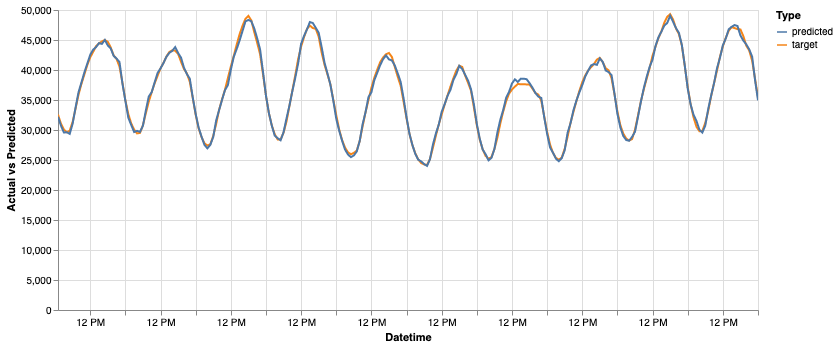

In [23]:
# Visualize the actual vs predicted chart for the last 2 days of the test data period
alt.Chart(actual_vs_pred_df_long[actual_vs_pred_df_long.Datetime > '2018-07-24']).mark_line().encode(
    x=alt.X('Datetime', type='temporal', title='Datetime'),
    y=alt.Y('value', type='quantitative', title='Actual vs Predicted'),
    color=alt.Color('variable', title='Type')
).properties(
    width=700
).interactive()

In [24]:
print(f'MAPE for test set: {mape(actual_vs_pred_df["target"], actual_vs_pred_df["predicted"])}')

MAPE for test set: 0.9109370478794194
